# **Inatall and Load Packages**

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, ReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Input
from matplotlib import pyplot
# Import the unsupervised context normalization layer
import os
import sys
package_dir = os.getcwd()
root_dir = os.path.dirname(package_dir)
sys.path.append(root_dir)
from normalization.layers import UnsupervisedContextNormalization

# **Create Generator and Discriminator**

In [ ]:
# Define the standalone discriminator model
def define_discriminator(in_shape=(32, 32, 3)):
    in_image = Input(shape=in_shape)
    # Normal
    x = Conv2D(64, (3, 3), padding='same')(in_image)
    x = LeakyReLU(alpha=0.2)(x)
    # Downsample
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    # Downsample
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    # Downsample
    x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    # Classifier
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(in_image, x)

    # Compile model
    opt = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.9)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

# Define the standalone generator model
def define_generator(latent_dim):
    in_lat = Input(shape=(latent_dim,))
    # Foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    x = Dense(n_nodes)(in_lat)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((4, 4, 256))(x)

    # Upsample to 8x8
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = UnsupervisedContextNormalization(num_components=3, epsilon=1e-3, momentum=0.9)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)

    # Upsample to 16x16
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = UnsupervisedContextNormalization(num_components=3, epsilon=1e-3, momentum=0.9)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)

    # Upsample to 32x32
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)

    # Output layer
    x = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

    model = Model(in_lat, x)

    return model


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.9)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# load and prepare cifar10 training images
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input, verbose=0)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
     # scale from [-1,1] to [0,1]
     examples = (examples + 1) / 2.0
     # plot images
     for i in range(n * n):
         # define subplot
         pyplot.subplot(n, n, 1 + i)
         # turn off axis
         pyplot.axis('off')
         # plot raw pixel data
         pyplot.imshow(examples[i])
     # save plot to file
     filename = 'generated_plot_e%03d.png' % (epoch+1)
     pyplot.savefig(filename)
     pyplot.show()


In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
     # prepare real samples
     X_real, y_real = generate_real_samples(dataset, n_samples)
     # evaluate discriminator on real examples
     _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
     # prepare fake examples
     x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
     # evaluate discriminator on fake examples
     _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
     # summarize discriminator performance
     print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
     # save plot
     save_plot(x_fake, epoch)
     # save the generator model tile file
     filename = 'generator_model_%03d.h5' % (epoch+1)
     g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
     bat_per_epo = int(dataset.shape[0] / n_batch)
     half_batch = int(n_batch / 2)
     # manually enumerate epochs
     for i in range(n_epochs):
     # enumerate batches over the training set
         for j in range(bat_per_epo):
             # get randomly selected 'real' samples
             X_real, y_real = generate_real_samples(dataset, half_batch)
             # update discriminator model weights
             d_loss1, _ = d_model.train_on_batch(X_real, y_real)
             # generate 'fake' examples
             X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
             # update discriminator model weights
             d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
             # prepare points in latent space as input for the generator
             X_gan = generate_latent_points(latent_dim, n_batch)
             # create inverted labels for the fake samples
             y_gan = ones((n_batch, 1))
             # update the generator via the discriminator's error
             g_loss = gan_model.train_on_batch(X_gan, y_gan)
             # summarize loss on this batch
         print('epoch %d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
         (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
         # evaluate the model performance, sometimes
         if (i+1) % 10 == 0:
             summarize_performance(i, g_model, d_model, dataset, latent_dim)

# **Train the model**

170498071/170498071 [==============================] - 3s 0us/step
epoch 1, 390/390, d1=0.512, d2=0.959 g=1.455
epoch 2, 390/390, d1=0.664, d2=0.670 g=0.782
epoch 3, 390/390, d1=0.665, d2=0.718 g=0.758
epoch 4, 390/390, d1=0.666, d2=0.677 g=0.761
epoch 5, 390/390, d1=0.710, d2=0.669 g=0.901
epoch 6, 390/390, d1=0.660, d2=0.668 g=0.744
epoch 7, 390/390, d1=0.660, d2=0.698 g=0.755
epoch 8, 390/390, d1=0.731, d2=0.663 g=1.083
epoch 9, 390/390, d1=0.674, d2=0.672 g=0.772
epoch 10, 390/390, d1=0.694, d2=0.796 g=0.747
>Accuracy real: 50%, fake: 71%


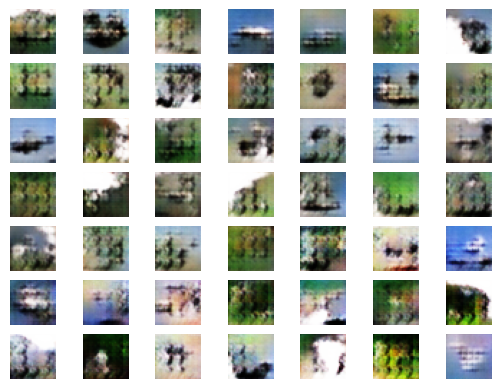

epoch 11, 390/390, d1=0.694, d2=0.666 g=0.775
epoch 12, 390/390, d1=0.671, d2=0.702 g=0.783
epoch 13, 390/390, d1=0.660, d2=0.699 g=0.717
epoch 14, 390/390, d1=0.679, d2=0.704 g=0.752
epoch 15, 390/390, d1=0.664, d2=0.731 g=0.736
epoch 16, 390/390, d1=0.669, d2=0.738 g=0.704
epoch 17, 390/390, d1=0.665, d2=0.922 g=0.718
epoch 18, 390/390, d1=0.681, d2=0.733 g=0.733
epoch 19, 390/390, d1=0.696, d2=0.708 g=0.733
epoch 20, 390/390, d1=0.674, d2=0.678 g=0.735
>Accuracy real: 47%, fake: 81%


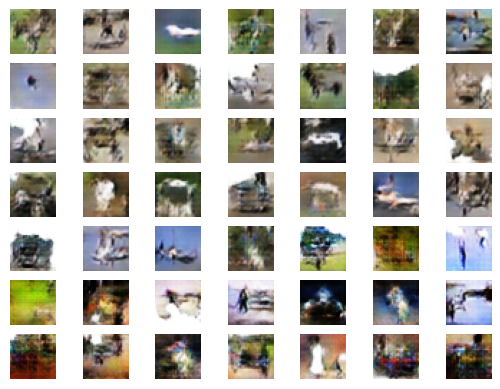

epoch 21, 390/390, d1=0.669, d2=0.694 g=0.715
epoch 22, 390/390, d1=0.655, d2=0.762 g=0.744
epoch 23, 390/390, d1=0.668, d2=0.725 g=0.718
epoch 24, 390/390, d1=0.677, d2=0.781 g=0.776
epoch 25, 390/390, d1=0.688, d2=0.683 g=0.736
epoch 26, 390/390, d1=0.677, d2=0.689 g=0.752
epoch 27, 390/390, d1=0.696, d2=0.639 g=0.753
epoch 28, 390/390, d1=0.656, d2=0.968 g=0.826
epoch 29, 390/390, d1=0.640, d2=0.709 g=0.738
epoch 30, 390/390, d1=0.689, d2=0.731 g=0.760
>Accuracy real: 45%, fake: 71%


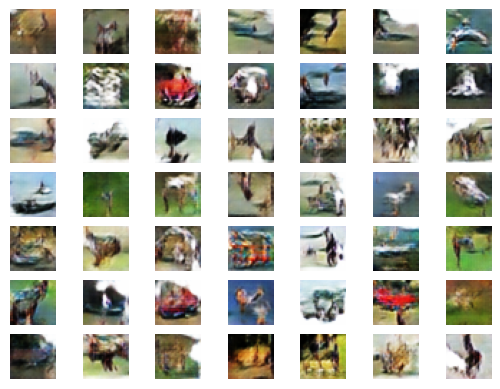

epoch 31, 390/390, d1=0.686, d2=0.713 g=0.758
epoch 32, 390/390, d1=0.693, d2=0.662 g=0.754
epoch 33, 390/390, d1=0.651, d2=0.712 g=0.768
epoch 34, 390/390, d1=0.692, d2=0.699 g=0.746
epoch 35, 390/390, d1=0.674, d2=0.639 g=0.775
epoch 36, 390/390, d1=0.701, d2=0.705 g=0.760
epoch 37, 390/390, d1=0.693, d2=0.657 g=0.752
epoch 38, 390/390, d1=0.697, d2=0.672 g=0.775
epoch 39, 390/390, d1=0.700, d2=0.691 g=0.768
epoch 40, 390/390, d1=0.665, d2=0.691 g=0.768
>Accuracy real: 41%, fake: 80%


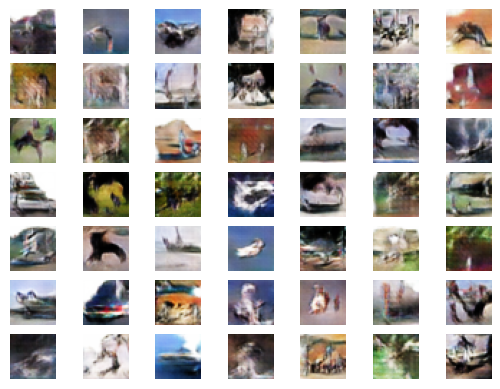

epoch 41, 390/390, d1=0.689, d2=0.679 g=0.768
epoch 42, 390/390, d1=0.686, d2=0.667 g=0.776
epoch 43, 390/390, d1=0.685, d2=0.715 g=0.777
epoch 44, 390/390, d1=0.671, d2=0.636 g=0.769
epoch 45, 390/390, d1=0.656, d2=0.693 g=0.753
epoch 46, 390/390, d1=0.705, d2=0.711 g=0.756
epoch 47, 390/390, d1=0.643, d2=0.628 g=0.764
epoch 48, 390/390, d1=0.644, d2=0.729 g=0.788
epoch 49, 390/390, d1=0.690, d2=0.666 g=0.767
epoch 50, 390/390, d1=0.684, d2=0.665 g=0.798
>Accuracy real: 51%, fake: 83%


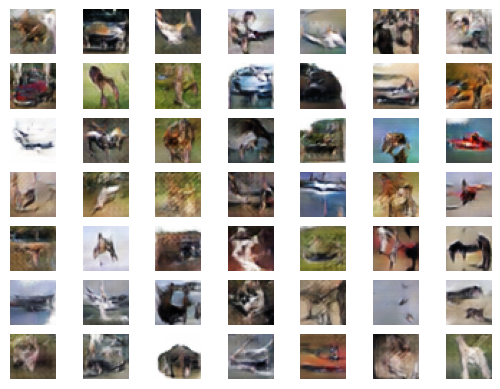

epoch 51, 390/390, d1=0.692, d2=0.656 g=0.797
epoch 52, 390/390, d1=0.662, d2=0.658 g=0.795
epoch 53, 390/390, d1=0.643, d2=0.701 g=0.793
epoch 54, 390/390, d1=0.708, d2=0.704 g=0.801
epoch 55, 390/390, d1=0.673, d2=0.670 g=0.781
epoch 56, 390/390, d1=0.685, d2=0.753 g=0.789
epoch 57, 390/390, d1=0.693, d2=0.698 g=0.795
epoch 58, 390/390, d1=0.652, d2=0.681 g=0.856
epoch 59, 390/390, d1=0.676, d2=0.632 g=0.771
epoch 60, 390/390, d1=0.689, d2=0.635 g=0.802
>Accuracy real: 43%, fake: 86%


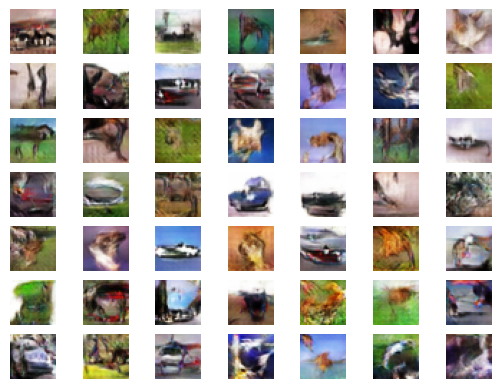

epoch 61, 390/390, d1=0.672, d2=0.644 g=0.802
epoch 62, 390/390, d1=0.665, d2=0.681 g=0.832
epoch 63, 390/390, d1=0.702, d2=0.673 g=0.830
epoch 64, 390/390, d1=0.735, d2=0.630 g=0.826
epoch 65, 390/390, d1=0.706, d2=0.699 g=0.818
epoch 66, 390/390, d1=0.765, d2=0.654 g=0.827
epoch 67, 390/390, d1=0.683, d2=0.670 g=0.796
epoch 68, 390/390, d1=0.650, d2=0.688 g=0.837
epoch 69, 390/390, d1=0.684, d2=0.619 g=0.838
epoch 70, 390/390, d1=0.672, d2=0.688 g=0.794
>Accuracy real: 49%, fake: 83%


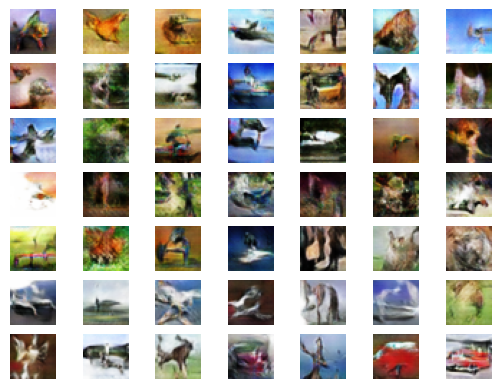

epoch 71, 390/390, d1=0.711, d2=0.607 g=0.817
epoch 72, 390/390, d1=0.636, d2=0.684 g=0.831
epoch 73, 390/390, d1=0.625, d2=0.646 g=0.849
epoch 74, 390/390, d1=0.697, d2=0.677 g=0.842
epoch 75, 390/390, d1=0.669, d2=0.644 g=0.856
epoch 76, 390/390, d1=0.661, d2=0.659 g=0.855
epoch 77, 390/390, d1=0.695, d2=0.679 g=0.827
epoch 78, 390/390, d1=0.645, d2=0.639 g=0.871
epoch 79, 390/390, d1=0.629, d2=0.671 g=0.881
epoch 80, 390/390, d1=0.658, d2=0.680 g=0.869
>Accuracy real: 55%, fake: 87%


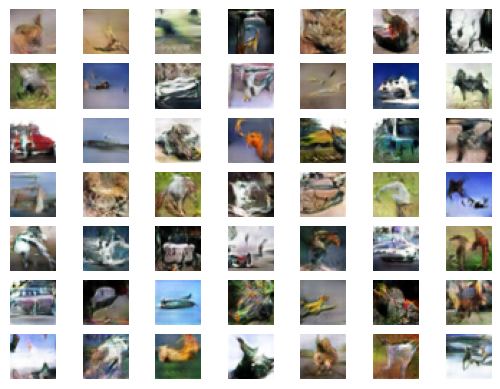

epoch 81, 390/390, d1=0.679, d2=0.638 g=0.859
epoch 82, 390/390, d1=0.704, d2=0.674 g=0.862
epoch 83, 390/390, d1=0.671, d2=0.709 g=0.935
epoch 84, 390/390, d1=0.609, d2=0.640 g=0.869
epoch 85, 390/390, d1=0.710, d2=0.579 g=0.849
epoch 86, 390/390, d1=0.679, d2=0.621 g=0.893
epoch 87, 390/390, d1=0.608, d2=0.691 g=0.869
epoch 88, 390/390, d1=0.679, d2=0.644 g=0.939
epoch 89, 390/390, d1=0.667, d2=0.626 g=0.887
epoch 90, 390/390, d1=0.651, d2=0.658 g=0.841
>Accuracy real: 58%, fake: 87%


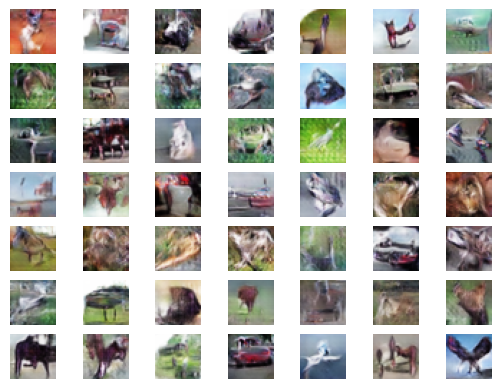

epoch 91, 390/390, d1=0.666, d2=0.593 g=0.992
epoch 92, 390/390, d1=0.684, d2=0.585 g=0.909
epoch 93, 390/390, d1=0.600, d2=0.590 g=0.914
epoch 94, 390/390, d1=0.618, d2=0.719 g=0.951
epoch 95, 390/390, d1=0.717, d2=0.595 g=0.859
epoch 96, 390/390, d1=0.621, d2=0.626 g=0.885
epoch 97, 390/390, d1=0.678, d2=0.620 g=0.957
epoch 98, 390/390, d1=0.682, d2=0.650 g=0.888
epoch 99, 390/390, d1=0.666, d2=0.649 g=0.903
epoch 100, 390/390, d1=0.736, d2=0.637 g=0.974
>Accuracy real: 56%, fake: 87%


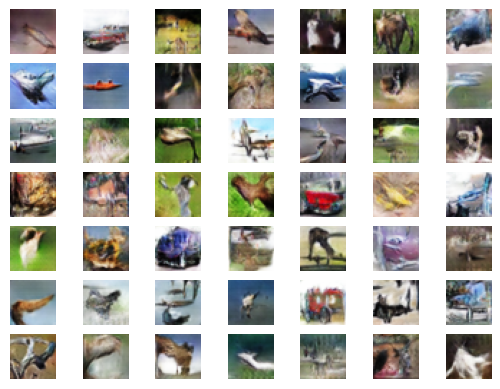

epoch 101, 390/390, d1=0.612, d2=0.627 g=0.919
epoch 102, 390/390, d1=0.646, d2=0.714 g=0.946
epoch 103, 390/390, d1=0.514, d2=0.718 g=0.913
epoch 104, 390/390, d1=0.690, d2=0.625 g=0.919
epoch 105, 390/390, d1=0.684, d2=0.607 g=0.879
epoch 106, 390/390, d1=0.673, d2=0.685 g=1.011
epoch 107, 390/390, d1=0.556, d2=0.741 g=0.971
epoch 108, 390/390, d1=0.652, d2=0.665 g=0.954
epoch 109, 390/390, d1=0.634, d2=0.625 g=0.961
epoch 110, 390/390, d1=0.741, d2=0.628 g=1.009
>Accuracy real: 65%, fake: 95%


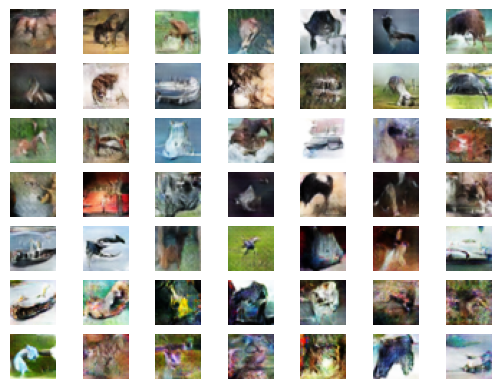

epoch 111, 390/390, d1=0.646, d2=0.670 g=1.036
epoch 112, 390/390, d1=0.640, d2=0.592 g=0.977
epoch 113, 390/390, d1=0.610, d2=0.646 g=0.957
epoch 114, 390/390, d1=0.702, d2=0.672 g=1.013
epoch 115, 390/390, d1=0.664, d2=0.615 g=0.929
epoch 116, 390/390, d1=0.684, d2=0.631 g=0.956
epoch 117, 390/390, d1=0.620, d2=0.698 g=0.945
epoch 118, 390/390, d1=0.615, d2=0.558 g=1.009
epoch 119, 390/390, d1=0.556, d2=0.629 g=0.944
epoch 120, 390/390, d1=0.576, d2=0.622 g=0.968
>Accuracy real: 59%, fake: 87%


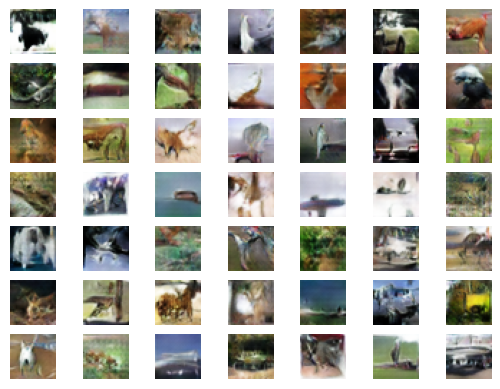

epoch 121, 390/390, d1=0.660, d2=0.681 g=0.969
epoch 122, 390/390, d1=0.701, d2=0.575 g=0.973
epoch 123, 390/390, d1=0.526, d2=0.626 g=0.965
epoch 124, 390/390, d1=0.632, d2=0.637 g=1.049
epoch 125, 390/390, d1=0.610, d2=0.613 g=0.998
epoch 126, 390/390, d1=0.703, d2=0.658 g=1.026
epoch 127, 390/390, d1=0.663, d2=0.661 g=0.996
epoch 128, 390/390, d1=0.625, d2=0.574 g=1.051
epoch 129, 390/390, d1=0.510, d2=0.507 g=1.013
epoch 130, 390/390, d1=0.601, d2=0.608 g=0.954
>Accuracy real: 58%, fake: 89%


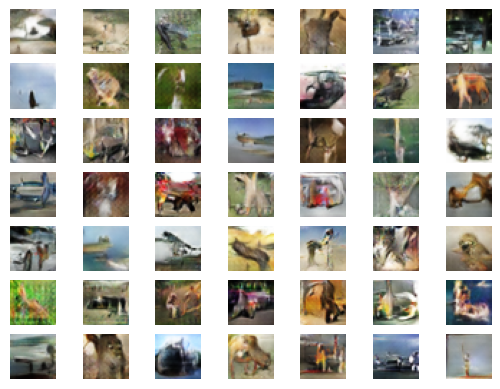

epoch 131, 390/390, d1=0.613, d2=0.603 g=1.091
epoch 132, 390/390, d1=0.583, d2=0.658 g=1.026
epoch 133, 390/390, d1=0.599, d2=0.510 g=1.034
epoch 134, 390/390, d1=0.596, d2=0.569 g=0.940
epoch 135, 390/390, d1=0.564, d2=0.591 g=1.016
epoch 136, 390/390, d1=0.512, d2=0.683 g=1.097
epoch 137, 390/390, d1=0.669, d2=0.618 g=1.036
epoch 138, 390/390, d1=0.548, d2=0.589 g=1.048
epoch 139, 390/390, d1=0.739, d2=0.611 g=1.060
epoch 140, 390/390, d1=0.574, d2=0.591 g=1.028
>Accuracy real: 57%, fake: 93%


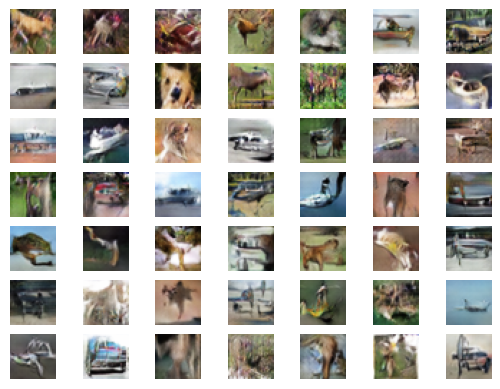

epoch 141, 390/390, d1=0.645, d2=0.606 g=1.012
epoch 142, 390/390, d1=0.599, d2=0.586 g=1.027
epoch 143, 390/390, d1=0.613, d2=0.624 g=1.093
epoch 144, 390/390, d1=0.587, d2=0.527 g=1.091
epoch 145, 390/390, d1=0.642, d2=0.668 g=1.043
epoch 146, 390/390, d1=0.640, d2=0.668 g=1.091
epoch 147, 390/390, d1=0.549, d2=0.606 g=1.041
epoch 148, 390/390, d1=0.603, d2=0.580 g=1.086
epoch 149, 390/390, d1=0.746, d2=0.679 g=1.125
epoch 150, 390/390, d1=0.619, d2=0.518 g=1.073
>Accuracy real: 63%, fake: 90%


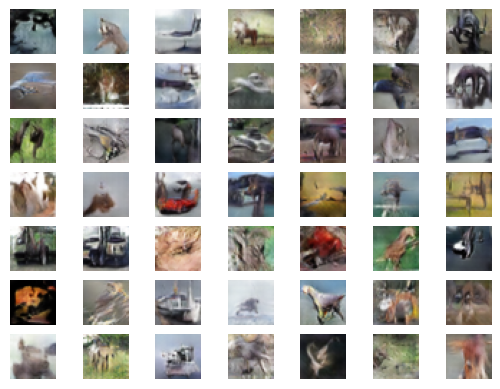

epoch 151, 390/390, d1=0.627, d2=0.566 g=1.084
epoch 152, 390/390, d1=0.701, d2=0.605 g=1.120
epoch 153, 390/390, d1=0.454, d2=0.648 g=1.095
epoch 154, 390/390, d1=0.625, d2=0.661 g=1.110
epoch 155, 390/390, d1=0.529, d2=0.511 g=1.076
epoch 156, 390/390, d1=0.660, d2=0.608 g=1.072
epoch 157, 390/390, d1=0.561, d2=0.622 g=1.078
epoch 158, 390/390, d1=0.614, d2=0.559 g=1.023
epoch 159, 390/390, d1=0.595, d2=0.664 g=1.174
epoch 160, 390/390, d1=0.607, d2=0.618 g=1.179
>Accuracy real: 60%, fake: 93%


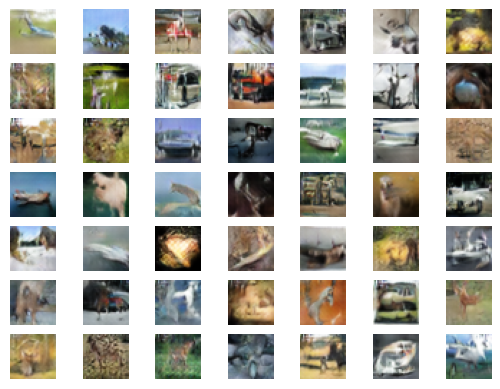

epoch 161, 390/390, d1=0.711, d2=0.622 g=1.142
epoch 162, 390/390, d1=0.504, d2=0.686 g=1.145
epoch 163, 390/390, d1=0.499, d2=0.561 g=1.120
epoch 164, 390/390, d1=0.630, d2=0.610 g=1.129
epoch 165, 390/390, d1=0.618, d2=0.626 g=1.166
epoch 166, 390/390, d1=0.605, d2=0.635 g=1.171
epoch 167, 390/390, d1=0.632, d2=0.546 g=1.257
epoch 168, 390/390, d1=0.529, d2=0.511 g=1.131
epoch 169, 390/390, d1=0.603, d2=0.570 g=1.094
epoch 170, 390/390, d1=0.625, d2=0.517 g=1.075
>Accuracy real: 65%, fake: 91%


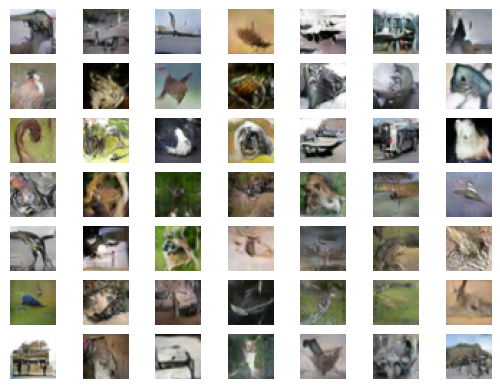

epoch 171, 390/390, d1=0.455, d2=0.567 g=1.171
epoch 172, 390/390, d1=0.624, d2=0.587 g=1.109
epoch 173, 390/390, d1=0.504, d2=0.689 g=1.155
epoch 174, 390/390, d1=0.621, d2=0.671 g=1.231
epoch 175, 390/390, d1=0.576, d2=0.585 g=1.177
epoch 176, 390/390, d1=0.614, d2=0.554 g=1.182
epoch 177, 390/390, d1=0.586, d2=0.509 g=1.227
epoch 178, 390/390, d1=0.677, d2=0.512 g=1.186
epoch 179, 390/390, d1=0.602, d2=0.580 g=1.133
epoch 180, 390/390, d1=0.602, d2=0.549 g=1.079
>Accuracy real: 60%, fake: 83%


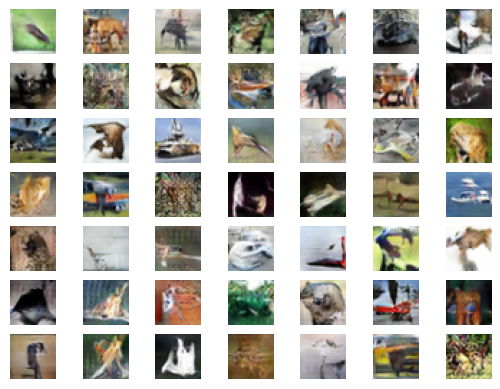

epoch 181, 390/390, d1=0.670, d2=0.648 g=1.186
epoch 182, 390/390, d1=0.710, d2=0.486 g=1.113
epoch 183, 390/390, d1=0.689, d2=0.562 g=1.142
epoch 184, 390/390, d1=0.689, d2=0.565 g=1.170
epoch 185, 390/390, d1=0.598, d2=0.496 g=1.153
epoch 186, 390/390, d1=0.631, d2=0.599 g=1.089
epoch 187, 390/390, d1=0.542, d2=0.499 g=1.205
epoch 188, 390/390, d1=0.542, d2=0.510 g=1.127
epoch 189, 390/390, d1=0.574, d2=0.554 g=1.133
epoch 190, 390/390, d1=0.550, d2=0.500 g=1.135
>Accuracy real: 63%, fake: 96%


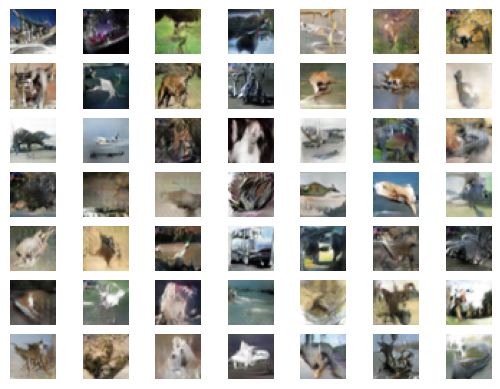

epoch 191, 390/390, d1=0.605, d2=0.543 g=1.210
epoch 192, 390/390, d1=0.631, d2=0.521 g=1.103
epoch 193, 390/390, d1=0.660, d2=0.622 g=1.132
epoch 194, 390/390, d1=0.613, d2=0.525 g=1.171
epoch 195, 390/390, d1=0.635, d2=0.545 g=1.198
epoch 196, 390/390, d1=0.605, d2=0.632 g=1.139
epoch 197, 390/390, d1=0.589, d2=0.593 g=1.280
epoch 198, 390/390, d1=0.381, d2=0.514 g=1.032
epoch 199, 390/390, d1=0.536, d2=0.631 g=1.183
epoch 200, 390/390, d1=0.518, d2=0.570 g=1.185
>Accuracy real: 73%, fake: 93%


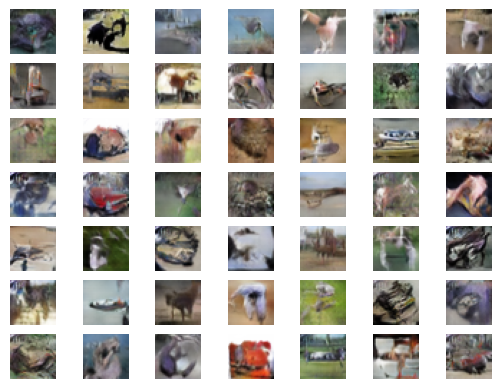

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [ ]:
# Save all models
! zip -r dcgan_unsupervised_acn_best.zip *

# **Test model with the last checkpoint**

In [ ]:
# example of loading the generator model and generating images
model = load_model('generator_model_200.h5', custom_objects={'UnsupervisedContextNormalization': UnsupervisedContextNormalization})
model.trainable=False
model.summary()

4/4 [==============================] - 0s 12ms/step


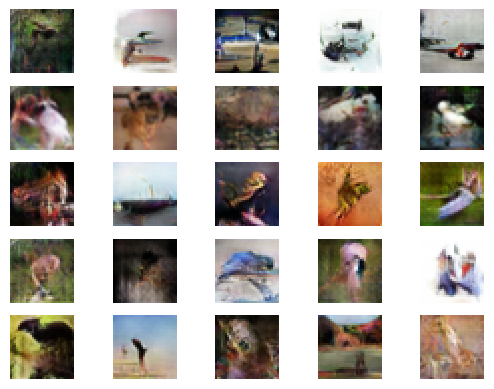

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# plot the generated images
def create_plot(examples, n):
    # plot images

    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])

    #pyplot.subplots_adjust(wspace=0, hspace=0)
    #pyplot.tight_layout(pad=-3)
    pyplot.savefig("dcgan_bn_save_bis_bis25.png",  bbox_inches="tight")
    pyplot.show()

# load model


# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = g_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

1/1 [==============================] - 0s 22ms/step


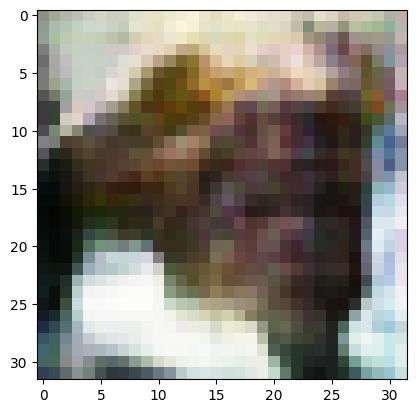

In [ ]:

# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
#model = load_model('generator_model_200.h5')
# all 0s
vector = asarray([[0.75 for _ in range(100)]])
# generate image
X = g_model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()